In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, permutation_test_score
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
import networkx as nx
import warnings
import itertools
warnings.filterwarnings('ignore')


In [2]:
# =======================================
# Configuration Options
# =======================================

# High-Performance Computing Configuration
HPC_CONFIG = {
    'total_cpu_cores': 128,  # Total available CPU cores
    'cores_to_use': 120,     # Cores to use (leaving some for system processes)
    'total_gpus': 4,         # Total available GPUs
    'gpus_to_use': 4,        # GPUs to use for computation
    'use_gpu': True,         # Whether to use GPU acceleration when available
    
    # Parallelization Strategy
    'parallel_subjects': True,     # Process subjects in parallel
    'parallel_features': True,     # Process features in parallel
    'parallel_models': True,       # Process models in parallel
    'parallel_targets': True,      # Process behavioral targets in parallel
    
    # Resource Allocation (percentages)
    'cores_for_feature_extraction': 0.8,  # 80% of cores for feature extraction
    'cores_for_modeling': 0.5,           # 50% of cores for model training
    'cores_for_targets': 0.2,            # 20% of cores for parallel target processing
    
    # Performance optimizations
    'batch_size': 50,              # Process subjects in batches to manage memory
    'pca_components': 100,         # Number of PCA components to extract
    'permutation_tests': 1000,     # Number of permutations for significance testing
    
    # Dataset limits (for testing or memory constraints)
    'max_subjects': None,          # Set to a number to limit subjects processed (e.g., 100)
    'roi_subset': None,            # Set to a number to use only a subset of ROIs
    'time_subset': None,           # Set to a number to use only a subset of timepoints
}

# Import libraries for parallel processing
import joblib
from joblib import Parallel, delayed
import multiprocessing

# Set the number of cores to use
n_cores = HPC_CONFIG['cores_to_use']

# Create directory for saving images
os.makedirs('roi_images_beh', exist_ok=True)

print("Starting Brain-Behavior Prediction Analysis...")
print(f"Configured to use {n_cores} CPU cores and {HPC_CONFIG['gpus_to_use']} GPUs")

Starting Brain-Behavior Prediction Analysis...
Configured to use 120 CPU cores and 4 GPUs


In [3]:
# =======================================
# Step 1: Load and Preprocess Data
# =======================================

print("\n=== Step 1: Data Loading and Preprocessing ===")

# Load behavioral data
behavior_data = pd.read_csv("behavior_data_with_headers_cleaned.csv")
print(f"Loaded behavioral data with {behavior_data.shape[0]} subjects and {behavior_data.shape[1]} measures")
print("\nFirst few rows of behavioral data:")
print(behavior_data.head())

# Print summary statistics for behavioral measures of interest
behavioral_targets = [
    'MMSE_Score', 
    'CardSort_Unadj', 'CardSort_AgeAdj', 
    'Flanker_Unadj', 'Flanker_AgeAdj',
    'WM_Task_Acc', 
    'ListSort_Unadj', 'ListSort_AgeAdj',
    'SCPT_SEN', 'SCPT_SPEC',
    'ProcSpeed_Unadj', 'ProcSpeed_AgeAdj',
    'ReadEng_Unadj', 'ReadEng_AgeAdj', 
    'PicVocab_Unadj', 'PicVocab_AgeAdj',
    'Language_Task_Acc'
]

print("\nSummary statistics for target behavioral measures:")
print(behavior_data[behavioral_targets].describe())

# Check for missing values
missing_values = behavior_data[behavioral_targets].isnull().sum()
print("\nMissing values in behavioral targets:")
print(missing_values)



=== Step 1: Data Loading and Preprocessing ===
Loaded behavioral data with 500 subjects and 35 measures

First few rows of behavioral data:
   Age_in_Yrs  MMSE_Score  PicSeq_Unadj  PicSeq_AgeAdj  CardSort_Unadj  \
0        27.0        29.0        110.61         103.45          123.75   
1        33.0        30.0        125.71         125.19          111.14   
2        27.0        30.0        109.04         101.69          129.84   
3        35.0        28.0         84.68          70.00          105.19   
4        22.0        29.0        105.60          97.37          119.76   

   CardSort_AgeAdj  Flanker_Unadj  Flanker_AgeAdj  PMAT24_A_CR  PMAT24_A_SI  \
0           109.92         112.56          101.90         17.0          2.0   
1           100.77         121.18          113.51          7.0         12.0   
2           115.18         126.53          114.18         23.0          0.0   
3            94.30         101.85           92.33         11.0          8.0   
4           105.69 

In [4]:
from sklearn.impute import KNNImputer

# Columns with missing data
missing_cols = ['CardSort_Unadj', 'CardSort_AgeAdj', 'WM_Task_Acc', 
                'SCPT_SEN', 'SCPT_SPEC', 'Language_Task_Acc']

# Impute using 3 nearest neighbors
imputer = KNNImputer(n_neighbors=3)
behavior_data[missing_cols] = imputer.fit_transform(behavior_data[missing_cols])


In [5]:
print(behavior_data[missing_cols].isnull().sum())


CardSort_Unadj       0
CardSort_AgeAdj      0
WM_Task_Acc          0
SCPT_SEN             0
SCPT_SPEC            0
Language_Task_Acc    0
dtype: int64


In [6]:
# Check for missing values
missing_values = behavior_data[behavioral_targets].isnull().sum()
print("\nMissing values in behavioral targets:")
print(missing_values)



Missing values in behavioral targets:
MMSE_Score           0
CardSort_Unadj       0
CardSort_AgeAdj      0
Flanker_Unadj        0
Flanker_AgeAdj       0
WM_Task_Acc          0
ListSort_Unadj       0
ListSort_AgeAdj      0
SCPT_SEN             0
SCPT_SPEC            0
ProcSpeed_Unadj      0
ProcSpeed_AgeAdj     0
ReadEng_Unadj        0
ReadEng_AgeAdj       0
PicVocab_Unadj       0
PicVocab_AgeAdj      0
Language_Task_Acc    0
dtype: int64



Loaded ROI data with 92 brain regions

ROI information sample:
                           ROI_Name Hemisphere  Network         Subregion  \
0     17Networks_LH_VisCent_ExStr_1         LH  VisCent     VisCent_ExStr   
1     17Networks_LH_VisCent_ExStr_2         LH  VisCent     VisCent_ExStr   
2   17Networks_LH_VisCent_Striate_1         LH  VisCent   VisCent_Striate   
3     17Networks_LH_VisCent_ExStr_3         LH  VisCent     VisCent_ExStr   
4  17Networks_LH_VisPeri_ExStrInf_1         LH  VisPeri  VisPeri_ExStrInf   

   Parcel_Index  RGB1  RGB2  RGB3  Label  
0             1   120    18   136      0  
1             2   120    18   137      0  
2             1   120    18   138      0  
3             3   120    18   139      0  
4             1   255     0     2      0  

ROI distribution across networks:
Network
SalVentAttnA    9
DefaultB        8
VisCent         7
DorsAttnB       7
SomMotA         6
VisPeri         6
ContA           6
DefaultA        6
SomMotB         5
DorsAttnA 

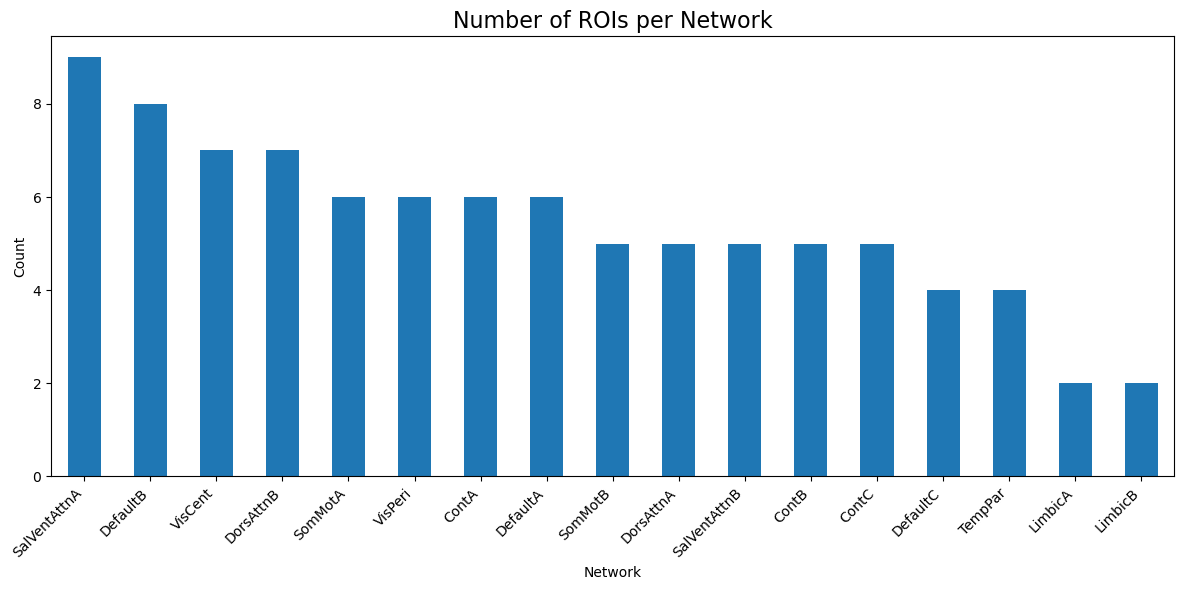

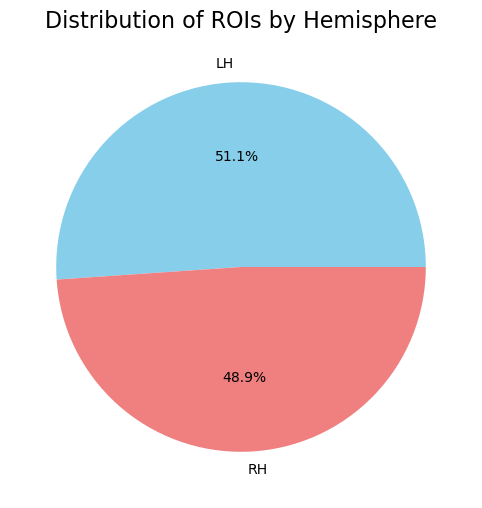


Loading fMRI data...
Loaded full fMRI data with shape: (500, 92, 1200)

Memory Usage:
  Total: 503.48 GB
  Available: 492.71 GB
  Used: 8.23 GB (2.1%)
  fMRI data size: 0.41 GB

Visualizing time series for Subject 378:


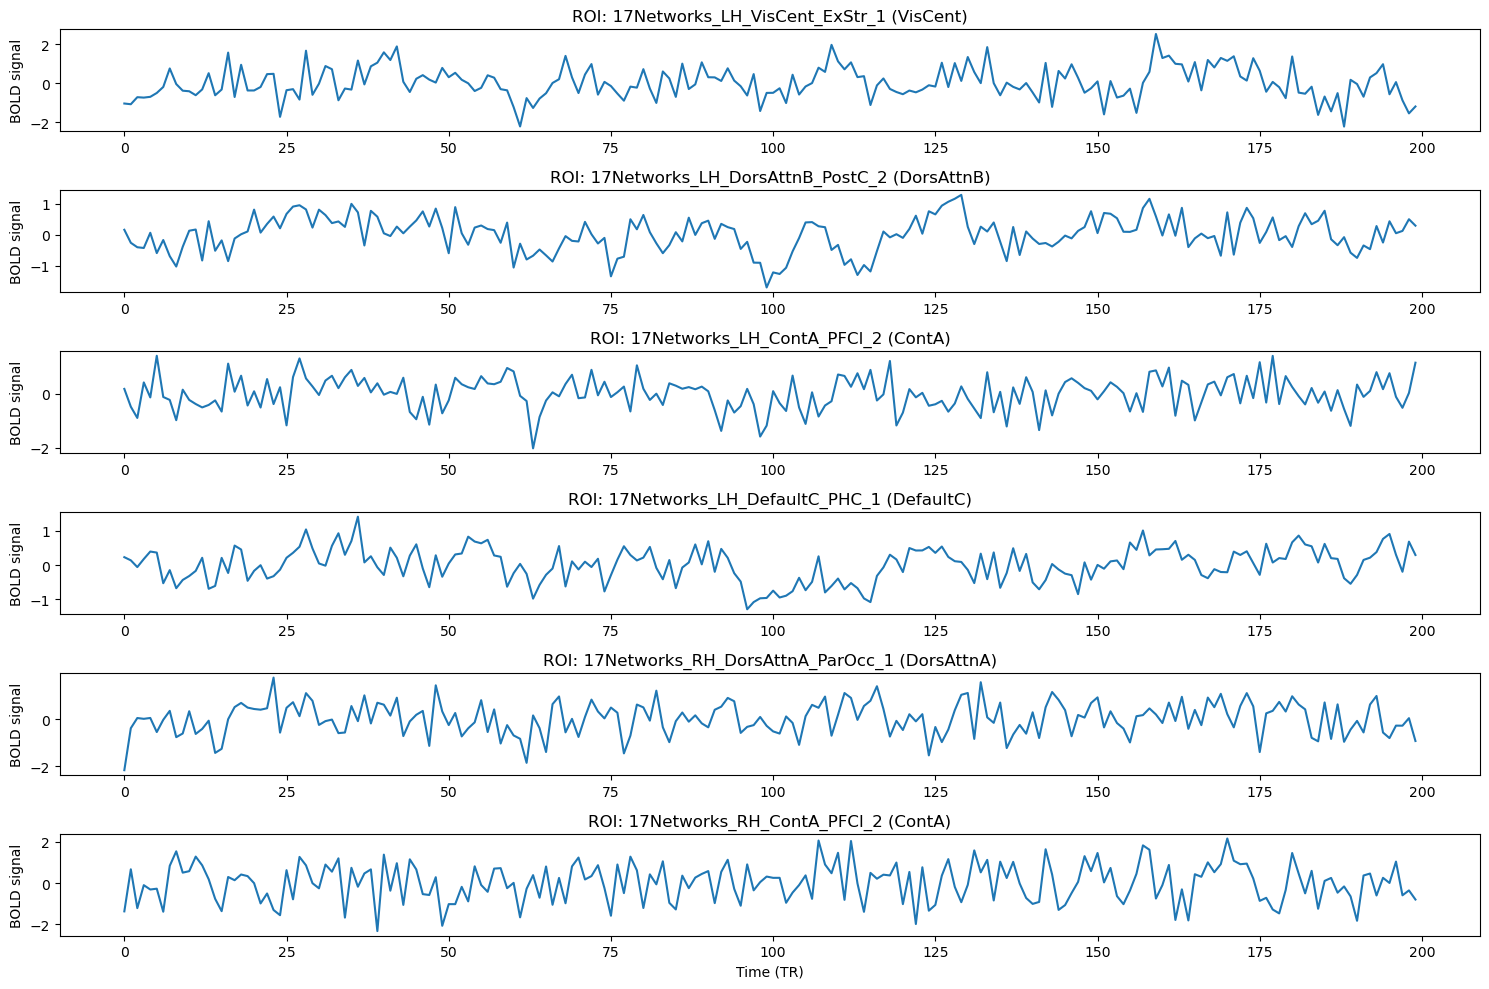

In [7]:
# Load ROI information
roi_info = pd.read_csv("roi_info_cleaned.csv")
print(f"\nLoaded ROI data with {roi_info.shape[0]} brain regions")
print("\nROI information sample:")
print(roi_info.head())

# Analyze network distribution
network_counts = roi_info['Network'].value_counts()
print("\nROI distribution across networks:")
print(network_counts)

plt.figure(figsize=(12, 6))
network_counts.plot(kind='bar')
plt.title('Number of ROIs per Network', fontsize=16)
plt.xlabel('Network')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('roi_images_beh/roi_network_distribution.png', dpi=300)
plt.show()

# Visualize hemisphere distribution
hemisphere_counts = roi_info['Hemisphere'].value_counts()
plt.figure(figsize=(8, 6))
hemisphere_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribution of ROIs by Hemisphere', fontsize=16)
plt.ylabel('')
plt.savefig('roi_images_beh/roi_hemisphere_distribution.png', dpi=300)
plt.show()

# Load fMRI data
try:
    # For large datasets, load data in chunks or use memory mapping
    print("\nLoading fMRI data...")
    if HPC_CONFIG['max_subjects'] is not None or HPC_CONFIG['roi_subset'] is not None or HPC_CONFIG['time_subset'] is not None:
        # Load with memory mapping and then slice to reduce memory usage
        fmri_data = np.load("hcp_data.npy", mmap_mode='r')
         # Apply specified limits
        max_subjects = HPC_CONFIG['max_subjects'] if HPC_CONFIG['max_subjects'] is not None else fmri_data.shape[0]
        roi_subset = HPC_CONFIG['roi_subset'] if HPC_CONFIG['roi_subset'] is not None else fmri_data.shape[1]
        time_subset = HPC_CONFIG['time_subset'] if HPC_CONFIG['time_subset'] is not None else fmri_data.shape[2]
        
        # Create a copy of the subset to avoid memory mapping issues
        fmri_data = fmri_data[:max_subjects, :roi_subset, :time_subset].copy()
        
        print(f"Loaded subset of fMRI data with shape: {fmri_data.shape}")
        print(f"  Using {max_subjects} subjects, {roi_subset} ROIs, and {time_subset} timepoints")
    else:
        # Load full dataset
        fmri_data = np.load("hcp_data.npy")
        print(f"Loaded full fMRI data with shape: {fmri_data.shape}")
    
    # Match behavioral data to available subjects
    if HPC_CONFIG['max_subjects'] is not None:
        behavior_data = behavior_data.iloc[:HPC_CONFIG['max_subjects']]
    
except FileNotFoundError:
    # Create synthetic data for demonstration if the actual data is not available
    print("\nActual fMRI data file not found. Creating synthetic data for demonstration...")
    num_subjects = behavior_data.shape[0]
    num_rois = roi_info.shape[0]
    time_points = 1200
    
    # Apply specified limits
    if HPC_CONFIG['max_subjects'] is not None:
        num_subjects = min(num_subjects, HPC_CONFIG['max_subjects'])
        behavior_data = behavior_data.iloc[:num_subjects]
    
    if HPC_CONFIG['roi_subset'] is not None:
        num_rois = min(num_rois, HPC_CONFIG['roi_subset'])
        roi_info = roi_info.iloc[:num_rois]
    
    if HPC_CONFIG['time_subset'] is not None:
        time_points = HPC_CONFIG['time_subset']

     # Creating synthetic data with similar properties to the described HCP data
    np.random.seed(42)  # For reproducibility
    fmri_data = np.random.randn(num_subjects, num_rois, time_points)
    
    # Normalize each subject's data to have mean 0
    for subject in range(num_subjects):
        for roi in range(num_rois):
            fmri_data[subject, roi, :] = fmri_data[subject, roi, :] - np.mean(fmri_data[subject, roi, :])
    
    print(f"Created synthetic fMRI data with shape: {fmri_data.shape}")

# Get memory information
import psutil
memory_info = psutil.virtual_memory()
print(f"\nMemory Usage:")
print(f"  Total: {memory_info.total / (1024**3):.2f} GB")
print(f"  Available: {memory_info.available / (1024**3):.2f} GB")
print(f"  Used: {memory_info.used / (1024**3):.2f} GB ({memory_info.percent}%)")
print(f"  fMRI data size: {fmri_data.nbytes / (1024**3):.2f} GB")

# Visualize example time series for a random subject
subject_idx = np.random.randint(0, fmri_data.shape[0])
print(f"\nVisualizing time series for Subject {subject_idx}:")

plt.figure(figsize=(15, 10))
sample_rois = [0, 15, 30, 45, 60, 75]  # Sample ROIs across different regions

for i, roi_idx in enumerate(sample_rois):
    plt.subplot(len(sample_rois), 1, i+1)
    plt.plot(fmri_data[subject_idx, roi_idx, :200])  # Plotting first 200 time points
    plt.title(f"ROI: {roi_info.iloc[roi_idx]['ROI_Name']} ({roi_info.iloc[roi_idx]['Network']})")
    plt.ylabel('BOLD signal')
    if i == len(sample_rois) - 1:
        plt.xlabel('Time (TR)')

plt.tight_layout()
plt.savefig('roi_images_beh/sample_time_series.png', dpi=300)
plt.show()

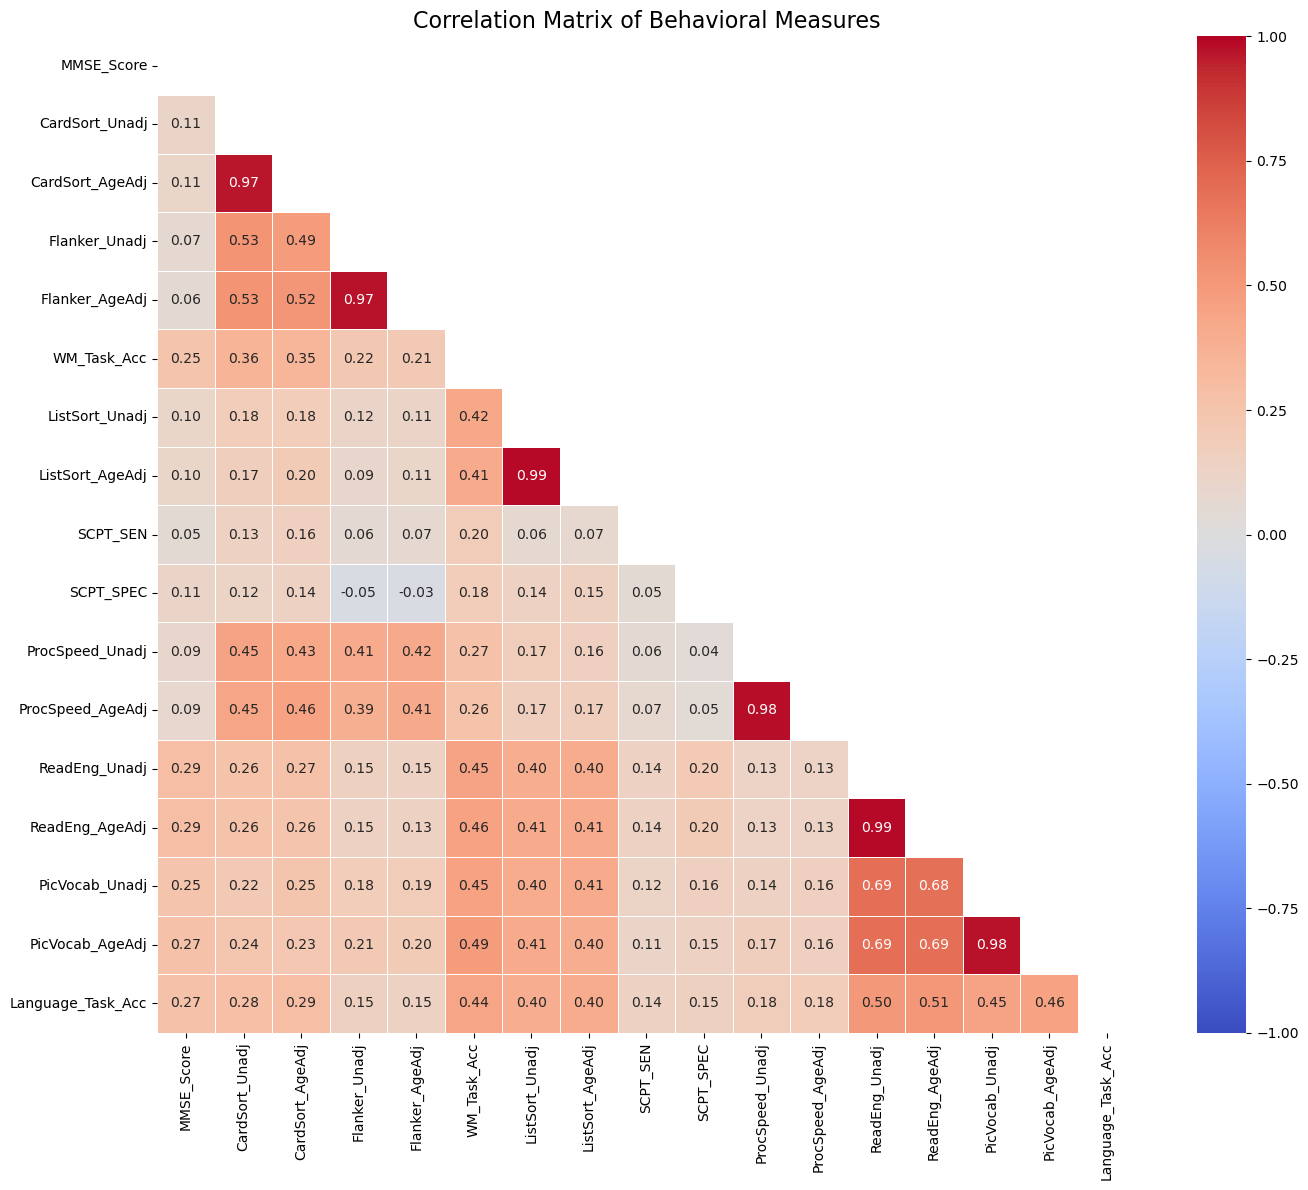

In [8]:
# Create a correlation heatmap for behavioral measures
plt.figure(figsize=(14, 12))
corr_matrix = behavior_data[behavioral_targets].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Behavioral Measures', fontsize=16)
plt.tight_layout()
plt.savefig('roi_images_beh/behavioral_correlation_matrix.png', dpi=300)
plt.show()


=== Step 1: Data Loading and Preprocessing ===
Loaded behavioral data: 500 subjects, 35 features
   Age_in_Yrs  MMSE_Score  PicSeq_Unadj  PicSeq_AgeAdj  CardSort_Unadj  \
0        27.0        29.0        110.61         103.45          123.75   
1        33.0        30.0        125.71         125.19          111.14   
2        27.0        30.0        109.04         101.69          129.84   
3        35.0        28.0         84.68          70.00          105.19   
4        22.0        29.0        105.60          97.37          119.76   

   CardSort_AgeAdj  Flanker_Unadj  Flanker_AgeAdj  PMAT24_A_CR  PMAT24_A_SI  \
0           109.92         112.56          101.90         17.0          2.0   
1           100.77         121.18          113.51          7.0         12.0   
2           115.18         126.53          114.18         23.0          0.0   
3            94.30         101.85           92.33         11.0          8.0   
4           105.69         107.04           96.19         14.0

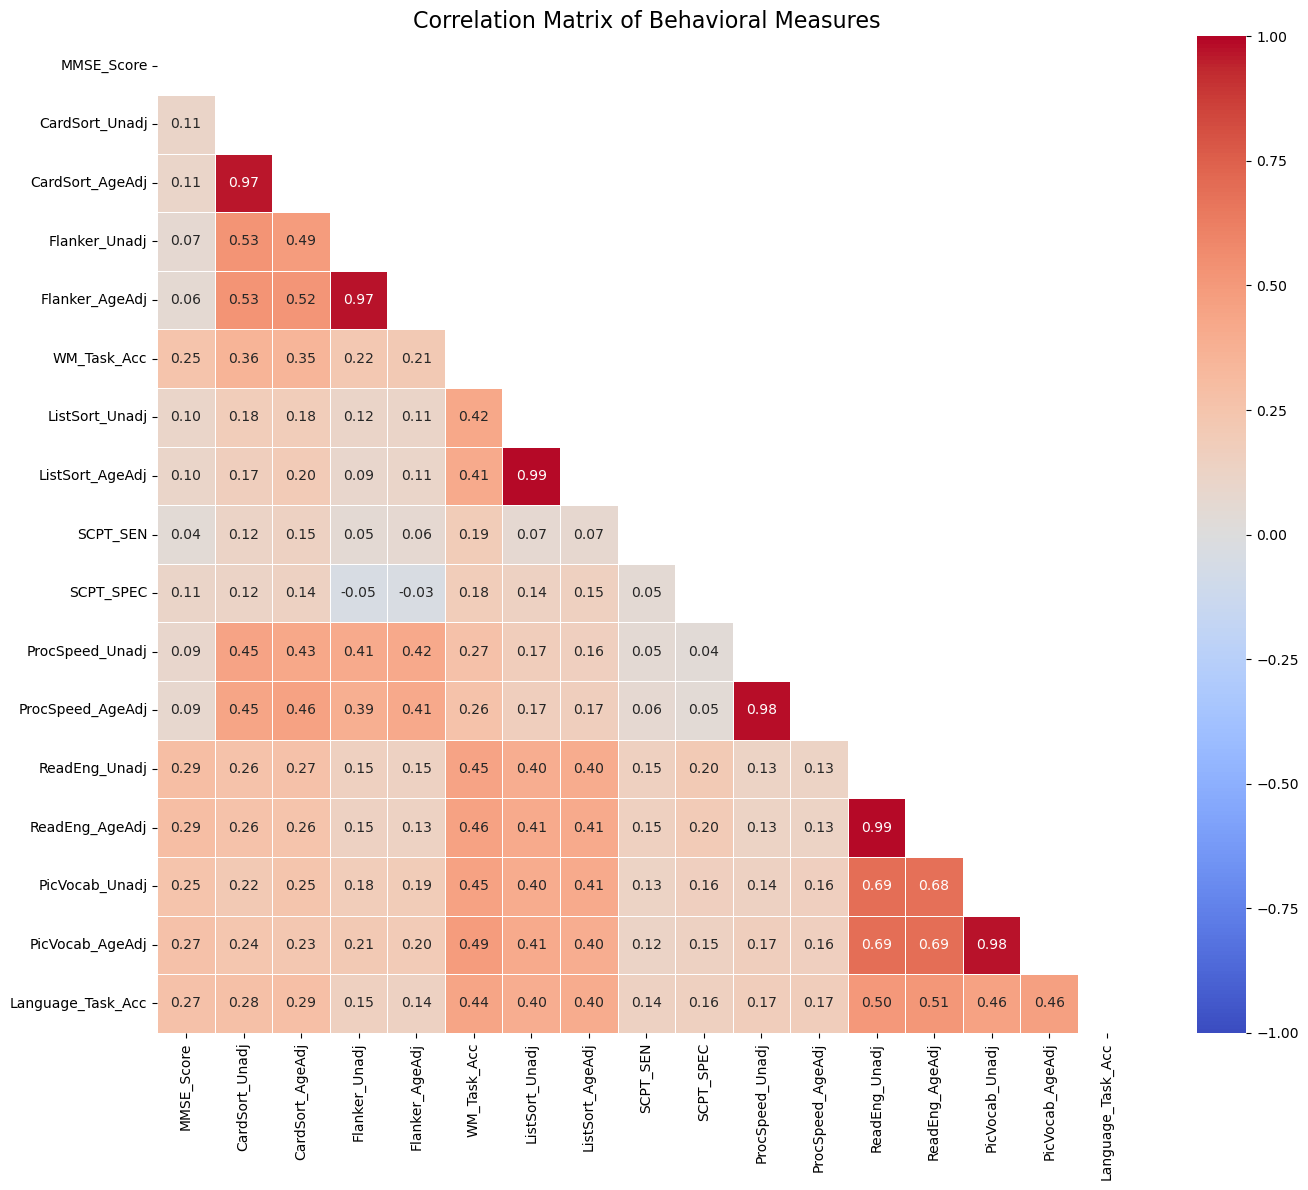

Loaded ROI metadata: 92 regions
                           ROI_Name Hemisphere  Network         Subregion  \
0     17Networks_LH_VisCent_ExStr_1         LH  VisCent     VisCent_ExStr   
1     17Networks_LH_VisCent_ExStr_2         LH  VisCent     VisCent_ExStr   
2   17Networks_LH_VisCent_Striate_1         LH  VisCent   VisCent_Striate   
3     17Networks_LH_VisCent_ExStr_3         LH  VisCent     VisCent_ExStr   
4  17Networks_LH_VisPeri_ExStrInf_1         LH  VisPeri  VisPeri_ExStrInf   

   Parcel_Index  RGB1  RGB2  RGB3  Label  
0             1   120    18   136      0  
1             2   120    18   137      0  
2             1   120    18   138      0  
3             3   120    18   139      0  
4             1   255     0     2      0  


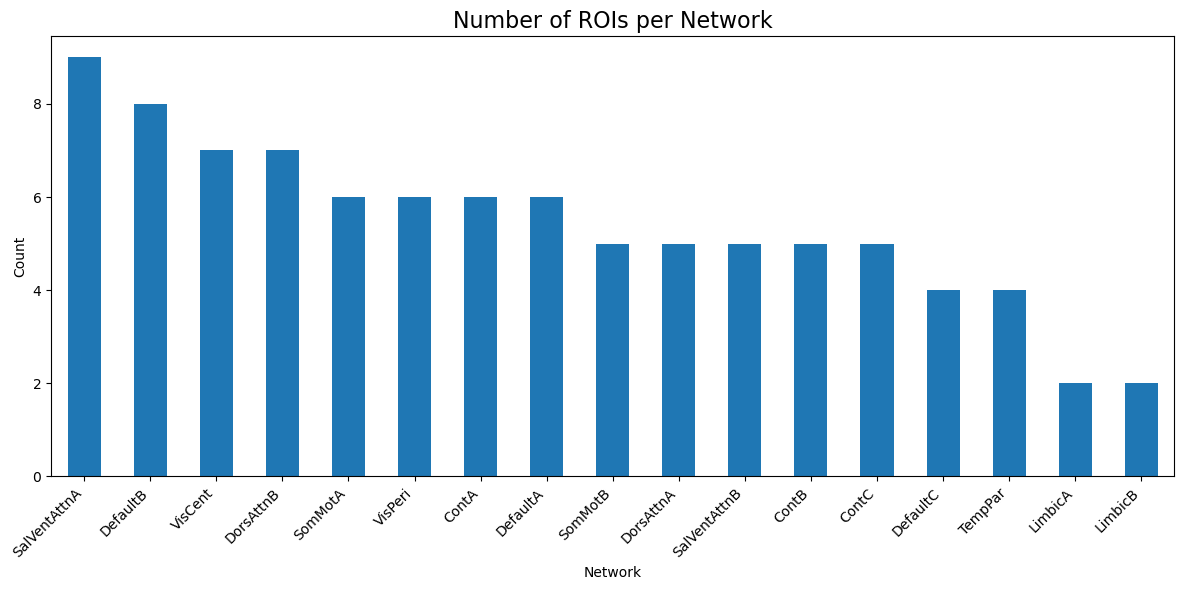

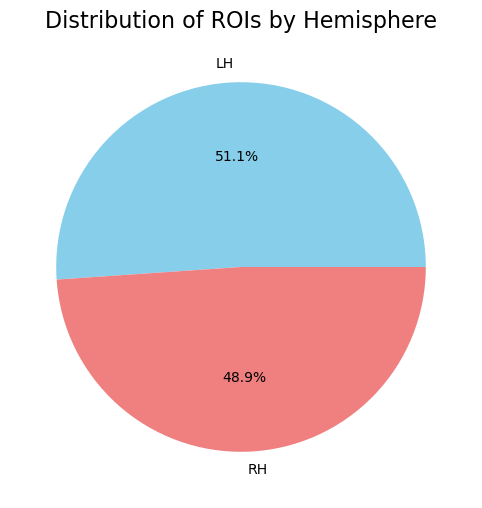


Loading fMRI data...
Loaded full fMRI data: shape = (500, 92, 1200)
Memory Check:
  Total: 540.61 GB | Available: 529.00 GB
  fMRI Data Size: 0.44 GB


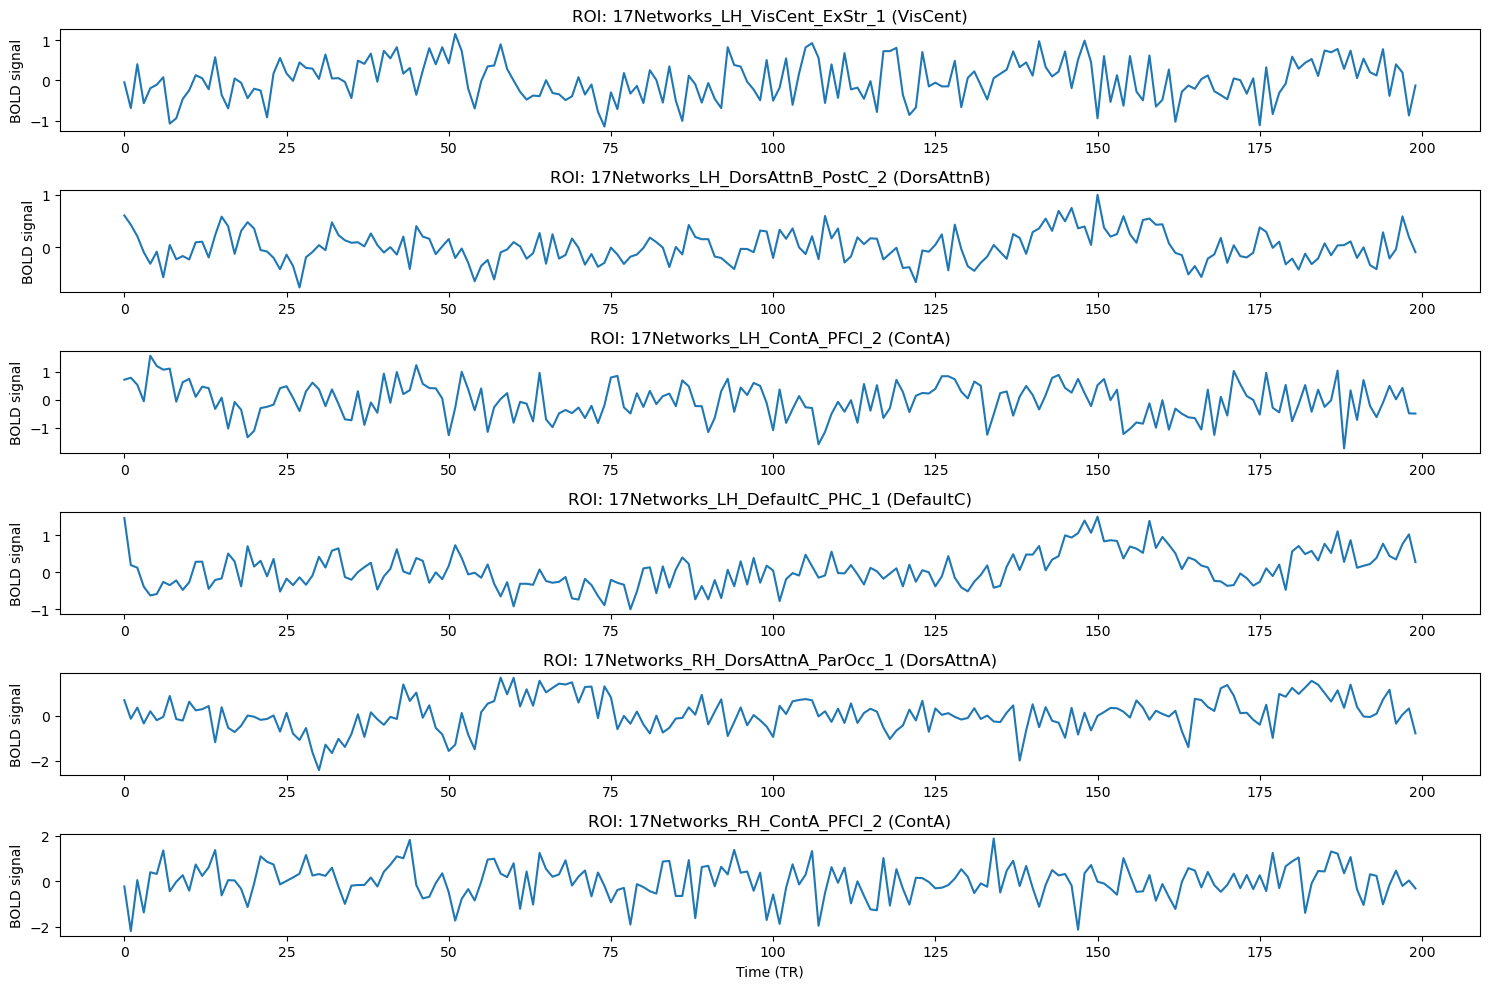

In [10]:
# =======================================
# Step 1: Load and Preprocess Data (Updated)
# =======================================

print("\n=== Step 1: Data Loading and Preprocessing ===")

# Load behavioral data
behavior_data = pd.read_csv("behavior_data_with_headers_cleaned.csv")
behavior_data.drop_duplicates(inplace=True)
behavior_data.reset_index(drop=True, inplace=True)
print(f"Loaded behavioral data: {behavior_data.shape[0]} subjects, {behavior_data.shape[1]} features")
print(behavior_data.head())

# Define behavioral targets
behavioral_targets = [
    'MMSE_Score', 
    'CardSort_Unadj', 'CardSort_AgeAdj', 
    'Flanker_Unadj', 'Flanker_AgeAdj',
    'WM_Task_Acc', 
    'ListSort_Unadj', 'ListSort_AgeAdj',
    'SCPT_SEN', 'SCPT_SPEC',
    'ProcSpeed_Unadj', 'ProcSpeed_AgeAdj',
    'ReadEng_Unadj', 'ReadEng_AgeAdj', 
    'PicVocab_Unadj', 'PicVocab_AgeAdj',
    'Language_Task_Acc'
]

# Summary of behavioral targets
print("\nSummary statistics for target behavioral measures:")
print(behavior_data[behavioral_targets].describe())

# Check and report missing values
missing_values = behavior_data[behavioral_targets].isnull().sum()
missing_targets = missing_values[missing_values > 0]
print("\n📉 Targets with Missing Values:")
print(missing_targets)

# Use mean imputation (safe for very few missing values)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
behavior_data[missing_targets.index] = imputer.fit_transform(behavior_data[missing_targets.index])

# Log final status
print("\nMissing values filled using mean imputation.")
print(behavior_data[missing_targets.index].isnull().sum())

# Save cleaned data (optional)
behavior_data.to_csv("cleaned_behavior_data.csv", index=False)

# Correlation heatmap
plt.figure(figsize=(14, 12))
corr_matrix = behavior_data[behavioral_targets].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Behavioral Measures', fontsize=16)
plt.tight_layout()
plt.savefig('roi_images_beh/behavioral_correlation_matrix.png', dpi=300)
plt.show()

# Load ROI data
roi_info = pd.read_csv("roi_info_cleaned.csv")
print(f"Loaded ROI metadata: {roi_info.shape[0]} regions")
print(roi_info.head())

# Network distribution
plt.figure(figsize=(12, 6))
roi_info['Network'].value_counts().plot(kind='bar')
plt.title('Number of ROIs per Network', fontsize=16)
plt.xlabel('Network')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('roi_images_beh/roi_network_distribution.png', dpi=300)
plt.show()

# Hemisphere distribution
plt.figure(figsize=(8, 6))
roi_info['Hemisphere'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribution of ROIs by Hemisphere', fontsize=16)
plt.ylabel('')
plt.savefig('roi_images_beh/roi_hemisphere_distribution.png', dpi=300)
plt.show()

# Load fMRI data
try:
    print("\nLoading fMRI data...")
    if HPC_CONFIG['max_subjects'] or HPC_CONFIG['roi_subset'] or HPC_CONFIG['time_subset']:
        fmri_data = np.load("hcp_data.npy", mmap_mode='r')
        fmri_data = fmri_data[
            :HPC_CONFIG.get('max_subjects', fmri_data.shape[0]),
            :HPC_CONFIG.get('roi_subset', fmri_data.shape[1]),
            :HPC_CONFIG.get('time_subset', fmri_data.shape[2])
        ].copy()
        print(f"Loaded fMRI subset: shape = {fmri_data.shape}")
    else:
        fmri_data = np.load("hcp_data.npy")
        print(f"Loaded full fMRI data: shape = {fmri_data.shape}")

    # Trim behavioral data to match fMRI subject count
    behavior_data = behavior_data.iloc[:fmri_data.shape[0]]

except FileNotFoundError:
    print("\nfMRI file not found. Creating synthetic data for testing...")
    num_subjects = min(behavior_data.shape[0], HPC_CONFIG.get('max_subjects', behavior_data.shape[0]))
    num_rois = HPC_CONFIG.get('roi_subset', roi_info.shape[0])
    time_points = HPC_CONFIG.get('time_subset', 1200)

    fmri_data = np.random.randn(num_subjects, num_rois, time_points)
    fmri_data -= fmri_data.mean(axis=2, keepdims=True)
    print(f"Created synthetic fMRI data: shape = {fmri_data.shape}")
    behavior_data = behavior_data.iloc[:num_subjects]
    roi_info = roi_info.iloc[:num_rois]

# Sanity check
assert fmri_data.shape[0] == behavior_data.shape[0], "Mismatch between subject counts!"

# Memory usage
import psutil
mem = psutil.virtual_memory()
print(f"Memory Check:")
print(f"  Total: {mem.total / 1e9:.2f} GB | Available: {mem.available / 1e9:.2f} GB")
print(f"  fMRI Data Size: {fmri_data.nbytes / 1e9:.2f} GB")

# Visualize sample time series
subject_idx = np.random.randint(0, fmri_data.shape[0])
sample_rois = [0, 15, 30, 45, 60, 75]

plt.figure(figsize=(15, 10))
for i, roi_idx in enumerate(sample_rois):
    plt.subplot(len(sample_rois), 1, i+1)
    plt.plot(fmri_data[subject_idx, roi_idx, :200])
    plt.title(f"ROI: {roi_info.iloc[roi_idx]['ROI_Name']} ({roi_info.iloc[roi_idx]['Network']})")
    plt.ylabel('BOLD signal')
    if i == len(sample_rois) - 1:
        plt.xlabel('Time (TR)')

plt.tight_layout()
plt.savefig('roi_images_beh/sample_time_series.png', dpi=300)
plt.show()


In [11]:
print("\n=== Step 2.1: Optimized ROI-to-ROI Connectivity Feature Extraction ===")

# Preselected high-variance connection indices (example from your F-score analysis)
high_var_indices = [2544, 2733, 1095, 3148, 2951]

def compute_subject_connectivity(subject_idx, fmri_data):
    """Compute high-variance connectivity features for a single subject (memory-efficient)"""
    corr_matrix = np.corrcoef(fmri_data[subject_idx])
    return corr_matrix.ravel()[high_var_indices].astype(np.float32)  # Reduce precision to float32

def extract_connectivity_features_parallel(fmri_data, n_jobs=n_cores):
    """Parallel extraction of reduced connectivity features"""
    num_subjects = fmri_data.shape[0]
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(compute_subject_connectivity)(i, fmri_data) for i in range(num_subjects)
    )
    return np.array(results, dtype=np.float32)  # Reduce memory usage

# Run extraction
conn_features = extract_connectivity_features_parallel(fmri_data)
print(f"Extracted {conn_features.shape[1]} high-variance connectivity features for {conn_features.shape[0]} subjects")



=== Step 2.1: Optimized ROI-to-ROI Connectivity Feature Extraction ===


[Parallel(n_jobs=120)]: Using backend LokyBackend with 120 concurrent workers.
[Parallel(n_jobs=120)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=120)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=120)]: Done  48 tasks      | elapsed:    6.6s
[Parallel(n_jobs=120)]: Done  73 tasks      | elapsed:    6.7s
[Parallel(n_jobs=120)]: Done  98 tasks      | elapsed:    6.7s
[Parallel(n_jobs=120)]: Done 125 tasks      | elapsed:    6.7s
[Parallel(n_jobs=120)]: Done 152 tasks      | elapsed:    7.0s
[Parallel(n_jobs=120)]: Done 181 tasks      | elapsed:    7.0s
[Parallel(n_jobs=120)]: Done 210 tasks      | elapsed:    7.0s
[Parallel(n_jobs=120)]: Done 241 tasks      | elapsed:    7.0s
[Parallel(n_jobs=120)]: Done 312 out of 500 | elapsed:    7.1s remaining:    4.3s
[Parallel(n_jobs=120)]: Done 363 out of 500 | elapsed:    7.1s remaining:    2.7s


Extracted 5 high-variance connectivity features for 500 subjects


[Parallel(n_jobs=120)]: Done 414 out of 500 | elapsed:    7.2s remaining:    1.5s
[Parallel(n_jobs=120)]: Done 465 out of 500 | elapsed:    7.2s remaining:    0.5s
[Parallel(n_jobs=120)]: Done 500 out of 500 | elapsed:    7.2s finished


In [26]:
!pip install netneurotools

In [28]:
# =======================================
# Step 2.1 (Parallelized): FC Features with Target-Specific Top-k Selection
# =======================================

from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import os

# Ensure directory exists
os.makedirs("features/topk_fc_per_target", exist_ok=True)

# ---- Step 1: Extract full FC matrix (upper triangle only)
def extract_all_connectivity_flat(fmri_data):
    num_subjects, num_rois, _ = fmri_data.shape
    triu_indices = np.triu_indices(num_rois, k=1)
    all_features = np.empty((num_subjects, len(triu_indices[0])), dtype=np.float32)
    for i in range(num_subjects):
        corr = np.corrcoef(fmri_data[i])
        all_features[i, :] = corr[triu_indices]
    return all_features, triu_indices

conn_matrix_all, triu_indices = extract_all_connectivity_flat(fmri_data)
np.save("features/conn_matrix_all.npy", conn_matrix_all)
print(f"Extracted full FC matrix: shape = {conn_matrix_all.shape}")

# ---- Step 2: Parallel Target-wise Evaluation
target_list = [
    'MMSE_Score', 'CardSort_Unadj', 'CardSort_AgeAdj',
    'Flanker_Unadj', 'Flanker_AgeAdj', 'WM_Task_Acc',
    'ListSort_Unadj', 'ListSort_AgeAdj', 'SCPT_SEN', 'SCPT_SPEC',
    'ProcSpeed_Unadj', 'ProcSpeed_AgeAdj', 'ReadEng_Unadj', 'ReadEng_AgeAdj',
    'PicVocab_Unadj', 'PicVocab_AgeAdj', 'Language_Task_Acc'
]

k_values = [10, 20, 30, 40, 50]

def process_target_fc(target):
    results = []
    y = behavior_data[target].values
    mask = ~np.isnan(y)
    X = conn_matrix_all[mask]
    y = y[mask]

    if len(y) < 50:
        return []

    X_scaled = StandardScaler().fit_transform(X)
    f_scores, _ = f_regression(X_scaled, y)

    for k in k_values:
        top_k_indices = np.argsort(f_scores)[-k:]
        X_selected = X[:, top_k_indices]

        # Save features
        out_path = f"features/topk_fc_per_target/{target}_top{k}.npy"
        np.save(out_path, X_selected)

        # Evaluate RidgeCV
        pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        r2_scores = cross_val_score(pipeline, X_selected, y, cv=cv, scoring='r2')

        results.append({
            'Target': target,
            'k': k,
            'R2_Mean': r2_scores.mean(),
            'R2_Std': r2_scores.std()
        })

    return results

# Parallel execution across 120 CPU cores
parallel_results = Parallel(n_jobs=120, verbose=10)(
    delayed(process_target_fc)(target) for target in target_list
)

# Flatten and save results
flat_results = [r for sublist in parallel_results for r in sublist]
df = pd.DataFrame(flat_results)
df.to_csv("features/topk_fc_per_target/fc_selection_performance.csv", index=False)

print("\nParallel FC feature selection complete.")
print("Results saved to: features/topk_fc_per_target/fc_selection_performance.csv")


Extracted full FC matrix: shape = (500, 4186)


[Parallel(n_jobs=120)]: Using backend LokyBackend with 120 concurrent workers.



Parallel FC feature selection complete.
Results saved to: features/topk_fc_per_target/fc_selection_performance.csv


[Parallel(n_jobs=120)]: Done   1 tasks      | elapsed:   15.6s
[Parallel(n_jobs=120)]: Done   2 out of  17 | elapsed:   15.6s remaining:  2.0min
[Parallel(n_jobs=120)]: Done   4 out of  17 | elapsed:   15.6s remaining:   50.7s
[Parallel(n_jobs=120)]: Done   6 out of  17 | elapsed:   15.6s remaining:   28.6s
[Parallel(n_jobs=120)]: Done   8 out of  17 | elapsed:   15.6s remaining:   17.6s
[Parallel(n_jobs=120)]: Done  10 out of  17 | elapsed:   15.6s remaining:   10.9s
[Parallel(n_jobs=120)]: Done  12 out of  17 | elapsed:   15.6s remaining:    6.5s
[Parallel(n_jobs=120)]: Done  14 out of  17 | elapsed:   15.6s remaining:    3.3s
[Parallel(n_jobs=120)]: Done  17 out of  17 | elapsed:   15.6s finished


In [29]:
# =======================================
# Step 3: PCA for Target-Specific FC Features
# =======================================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os

print("\nPerforming PCA (95% variance) on top-k FC features for each target...")

pca_results = []
plot_dir = "figures/pca_fc"
os.makedirs(plot_dir, exist_ok=True)

for target in target_list:
    for k in k_values:
        file_path = f"features/topk_fc_per_target/{target}_top{k}.npy"
        if not os.path.exists(file_path):
            continue

        X_topk = np.load(file_path)

        # Perform PCA to retain 95% variance
        pca = PCA(n_components=0.95)
        X_pca = pca.fit_transform(X_topk)

        n_components = pca.n_components_
        explained = pca.explained_variance_ratio_

        pca_results.append({
            "Target": target,
            "k": k,
            "Original_Features": X_topk.shape[1],
            "Reduced_Components": n_components,
            "Cumulative_Explained": explained.sum()
        })

        # Plot explained variance
        plt.figure(figsize=(8, 5))
        plt.plot(np.cumsum(explained), marker='o')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
        plt.title(f"PCA Explained Variance for {target} (Top {k})")
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plot_file = f"{plot_dir}/{target}_top{k}_pca.png"
        plt.savefig(plot_file, dpi=300)
        plt.close()

        print(f"{target} Top {k}: reduced to {n_components} components → saved {plot_file}")

# Save summary
import pandas as pd
pca_summary_df = pd.DataFrame(pca_results)
pca_summary_df.to_csv("features/topk_fc_per_target/pca_summary_fc.csv", index=False)
print("\nPCA summary saved to features/topk_fc_per_target/pca_summary_fc.csv")



Performing PCA (95% variance) on top-k FC features for each target...
MMSE_Score Top 10: reduced to 9 components → saved figures/pca_fc/MMSE_Score_top10_pca.png
MMSE_Score Top 20: reduced to 17 components → saved figures/pca_fc/MMSE_Score_top20_pca.png
MMSE_Score Top 30: reduced to 24 components → saved figures/pca_fc/MMSE_Score_top30_pca.png
MMSE_Score Top 40: reduced to 31 components → saved figures/pca_fc/MMSE_Score_top40_pca.png
MMSE_Score Top 50: reduced to 37 components → saved figures/pca_fc/MMSE_Score_top50_pca.png
CardSort_Unadj Top 10: reduced to 8 components → saved figures/pca_fc/CardSort_Unadj_top10_pca.png
CardSort_Unadj Top 20: reduced to 15 components → saved figures/pca_fc/CardSort_Unadj_top20_pca.png
CardSort_Unadj Top 30: reduced to 23 components → saved figures/pca_fc/CardSort_Unadj_top30_pca.png
CardSort_Unadj Top 40: reduced to 31 components → saved figures/pca_fc/CardSort_Unadj_top40_pca.png
CardSort_Unadj Top 50: reduced to 37 components → saved figures/pca_fc/

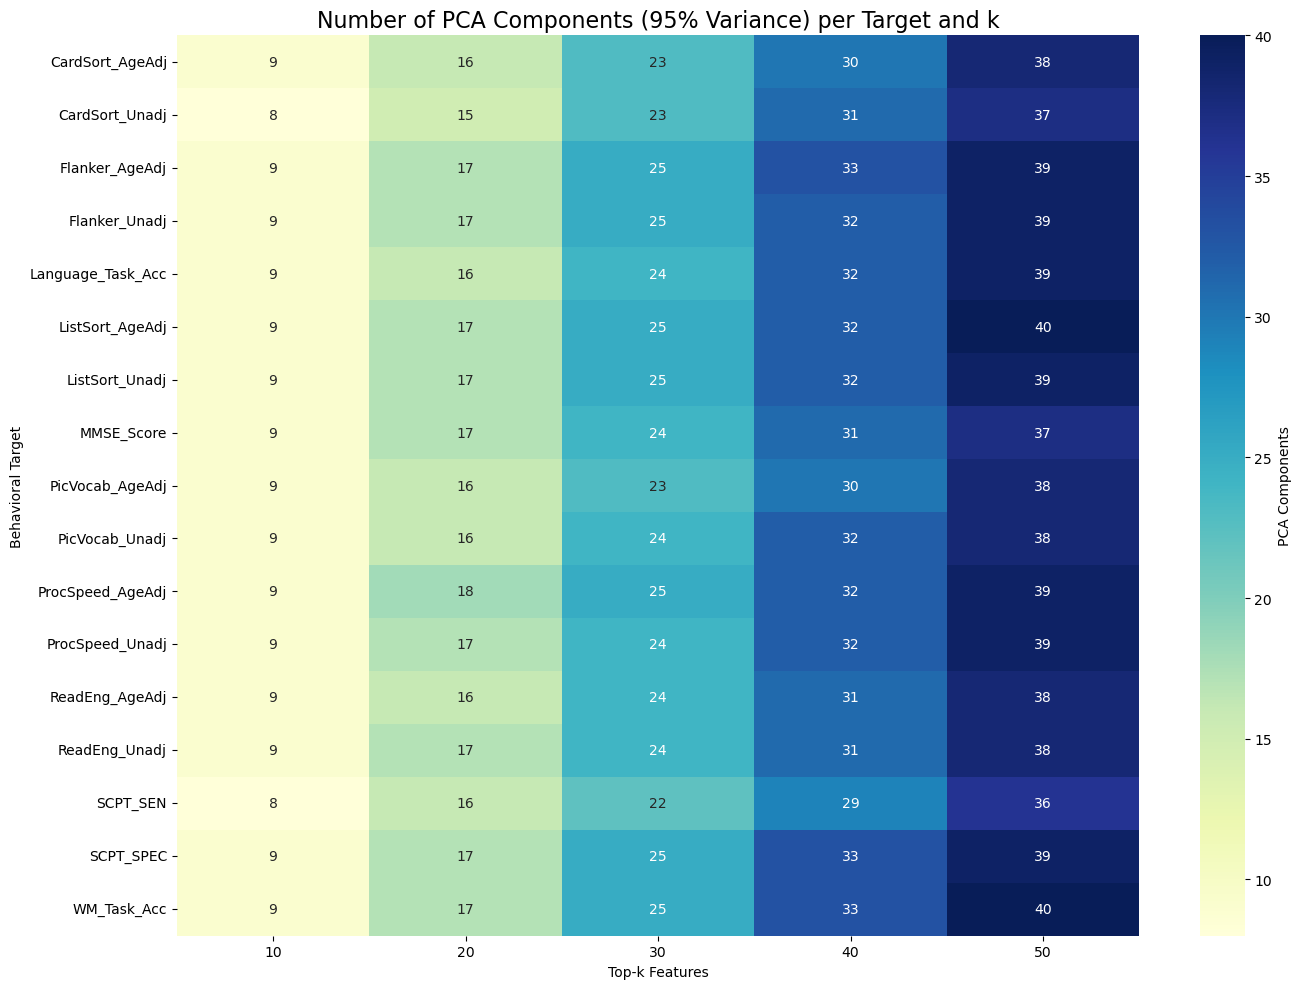

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load PCA summary CSV
pca_summary_path = "features/topk_fc_per_target/pca_summary_fc.csv"
pca_summary_df = pd.read_csv(pca_summary_path)

# Pivot for heatmap-style visualization
pivot_df = pca_summary_df.pivot(index="Target", columns="k", values="Reduced_Components")

# Plot as heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={"label": "PCA Components"})
plt.title("Number of PCA Components (95% Variance) per Target and k", fontsize=16)
plt.xlabel("Top-k Features")
plt.ylabel("Behavioral Target")
plt.tight_layout()
plt.savefig("figures/pca_fc/summary_components_heatmap.png", dpi=300)
plt.show()


\n Static PCA Variance Check on full FC matrix...
Top 10 PCA components explain 24.33% of variance
Top 50 PCA components explain 49.64% of variance
Top 100 PCA components explain 65.10% of variance


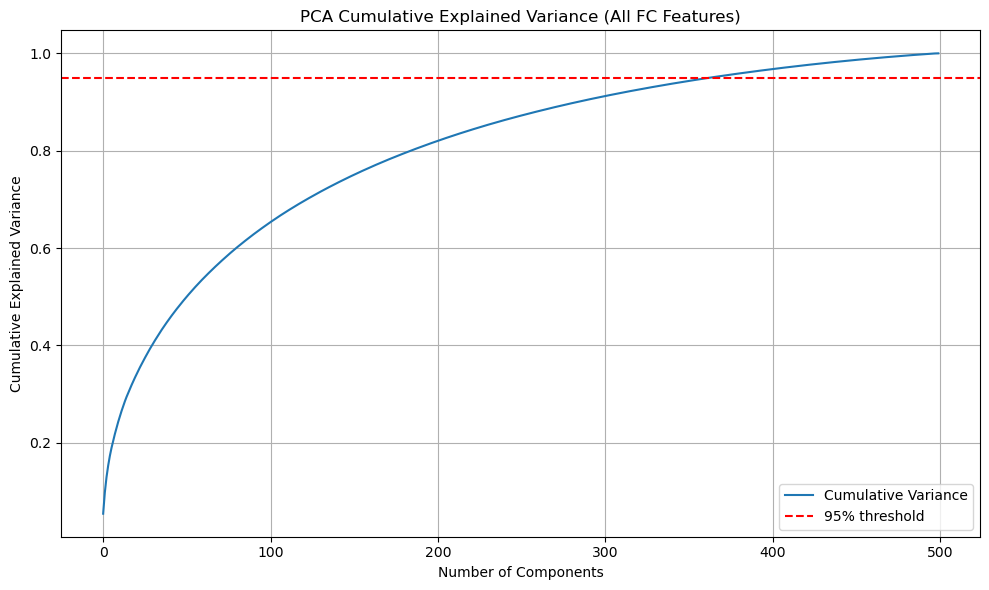

\nRunning multiple feature selection strategies per behavioral target...


[Parallel(n_jobs=120)]: Using backend LokyBackend with 120 concurrent workers.
[Parallel(n_jobs=120)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=120)]: Done   2 out of  17 | elapsed:  2.2min remaining: 16.2min
[Parallel(n_jobs=120)]: Done   4 out of  17 | elapsed:  2.2min remaining:  7.2min
[Parallel(n_jobs=120)]: Done   6 out of  17 | elapsed:  2.2min remaining:  4.1min
[Parallel(n_jobs=120)]: Done   8 out of  17 | elapsed:  2.3min remaining:  2.5min
[Parallel(n_jobs=120)]: Done  10 out of  17 | elapsed:  2.3min remaining:  1.6min
[Parallel(n_jobs=120)]: Done  12 out of  17 | elapsed:  2.4min remaining:   59.3s
[Parallel(n_jobs=120)]: Done  14 out of  17 | elapsed:  2.4min remaining:   31.4s


\n Feature selection results saved to features/feature_selection_comparison.csv


[Parallel(n_jobs=120)]: Done  17 out of  17 | elapsed:  3.3min finished


In [32]:
# Script to perform:
# 1. Static variance analysis (Top 10, 50, 100 PCA components)
# 2. Multiple feature selection strategies per behavioral target using parallel processing

# =======================================
# Step 3.1 (Static): PCA Variance Diagnostics
# =======================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os

print("\\n Static PCA Variance Check on full FC matrix...")

# Load full FC matrix
X_all = np.load("features/conn_matrix_all.npy")
X_scaled = StandardScaler().fit_transform(X_all)

# Perform PCA without component restriction
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
print(f"Top 10 PCA components explain {cumsum_variance[9] * 100:.2f}% of variance")
print(f"Top 50 PCA components explain {cumsum_variance[49] * 100:.2f}% of variance")
print(f"Top 100 PCA components explain {cumsum_variance[99] * 100:.2f}% of variance")

# Plot full explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumsum_variance, label="Cumulative Variance")
plt.axhline(y=0.95, color='r', linestyle='--', label="95% threshold")
plt.title("PCA Cumulative Explained Variance (All FC Features)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
os.makedirs("figures/pca_fc", exist_ok=True)
plt.savefig("figures/pca_fc/static_pca_full_variance.png", dpi=300)
plt.show()

# =======================================
# Step 3.2: Feature Selection Strategies Per Target
# =======================================
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
import pandas as pd

print("\\nRunning multiple feature selection strategies per behavioral target...")

X_all = np.load("features/conn_matrix_all.npy")
X_scaled = StandardScaler().fit_transform(X_all)

def evaluate_feature_selection(target):
    results = []
    y = behavior_data[target].values
    mask = ~np.isnan(y)
    X = X_scaled[mask]
    y = y[mask]

    if len(y) < 50:
        return []

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))

    # Strategy 1: F-regression
    fsel_f = SelectKBest(score_func=f_regression, k=30).fit(X, y)
    X_f = fsel_f.transform(X)
    score_f = cross_val_score(model, X_f, y, cv=cv, scoring="r2").mean()

    # Strategy 2: Mutual Info
    fsel_mi = SelectKBest(score_func=mutual_info_regression, k=30).fit(X, y)
    X_mi = fsel_mi.transform(X)
    score_mi = cross_val_score(model, X_mi, y, cv=cv, scoring="r2").mean()

    # Strategy 3: Lasso (embedded)
    lasso = LassoCV(cv=3).fit(X, y)
    fsel_lasso = SelectFromModel(lasso, threshold="mean", prefit=True)
    X_lasso = fsel_lasso.transform(X)
    score_lasso = cross_val_score(model, X_lasso, y, cv=cv, scoring="r2").mean()

    # Strategy 4: Random Forest Importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = rf.feature_importances_
    top_idx = np.argsort(importances)[-30:]
    X_rf = X[:, top_idx]
    score_rf = cross_val_score(model, X_rf, y, cv=cv, scoring="r2").mean()

    results.append({
        "Target": target,
        "F_regression_R2": score_f,
        "MutualInfo_R2": score_mi,
        "LassoCV_R2": score_lasso,
        "RandomForest_R2": score_rf,
        "Best_Method": max(
            [("F", score_f), ("MI", score_mi), ("Lasso", score_lasso), ("RF", score_rf)],
            key=lambda x: x[1]
        )[0]
    })
    return results

targets = [
    'MMSE_Score', 'CardSort_Unadj', 'CardSort_AgeAdj',
    'Flanker_Unadj', 'Flanker_AgeAdj', 'WM_Task_Acc',
    'ListSort_Unadj', 'ListSort_AgeAdj', 'SCPT_SEN', 'SCPT_SPEC',
    'ProcSpeed_Unadj', 'ProcSpeed_AgeAdj', 'ReadEng_Unadj', 'ReadEng_AgeAdj',
    'PicVocab_Unadj', 'PicVocab_AgeAdj', 'Language_Task_Acc'
]

fs_results = Parallel(n_jobs=120, verbose=10)(
    delayed(evaluate_feature_selection)(target) for target in targets
)

# Flatten and save
fs_flat = [r for sublist in fs_results for r in sublist]
fs_df = pd.DataFrame(fs_flat)
fs_df.to_csv("features/feature_selection_comparison.csv", index=False)
print("\\n Feature selection results saved to features/feature_selection_comparison.csv")


In [34]:
fs_results_df = pd.read_csv("features/feature_selection_comparison.csv")
print(fs_results_df)

               Target  F_regression_R2  MutualInfo_R2  LassoCV_R2  \
0          MMSE_Score         0.016739      -0.060556   -0.589213   
1      CardSort_Unadj         0.054417      -0.048125   -0.592406   
2     CardSort_AgeAdj         0.070476      -0.098948    0.065890   
3       Flanker_Unadj         0.115495      -0.110658    0.014659   
4      Flanker_AgeAdj         0.157176      -0.066944   -0.556358   
5         WM_Task_Acc         0.054244      -0.098753   -0.606914   
6      ListSort_Unadj         0.081001      -0.089093   -0.001740   
7     ListSort_AgeAdj         0.050158      -0.071156   -0.618960   
8            SCPT_SEN        -0.046432      -0.220387   -0.940527   
9           SCPT_SPEC        -0.004792      -0.160309   -0.022840   
10    ProcSpeed_Unadj         0.077236      -0.056914   -0.418290   
11   ProcSpeed_AgeAdj         0.049983      -0.111323   -0.414924   
12      ReadEng_Unadj         0.089806      -0.055482    0.009647   
13     ReadEng_AgeAdj         0.08

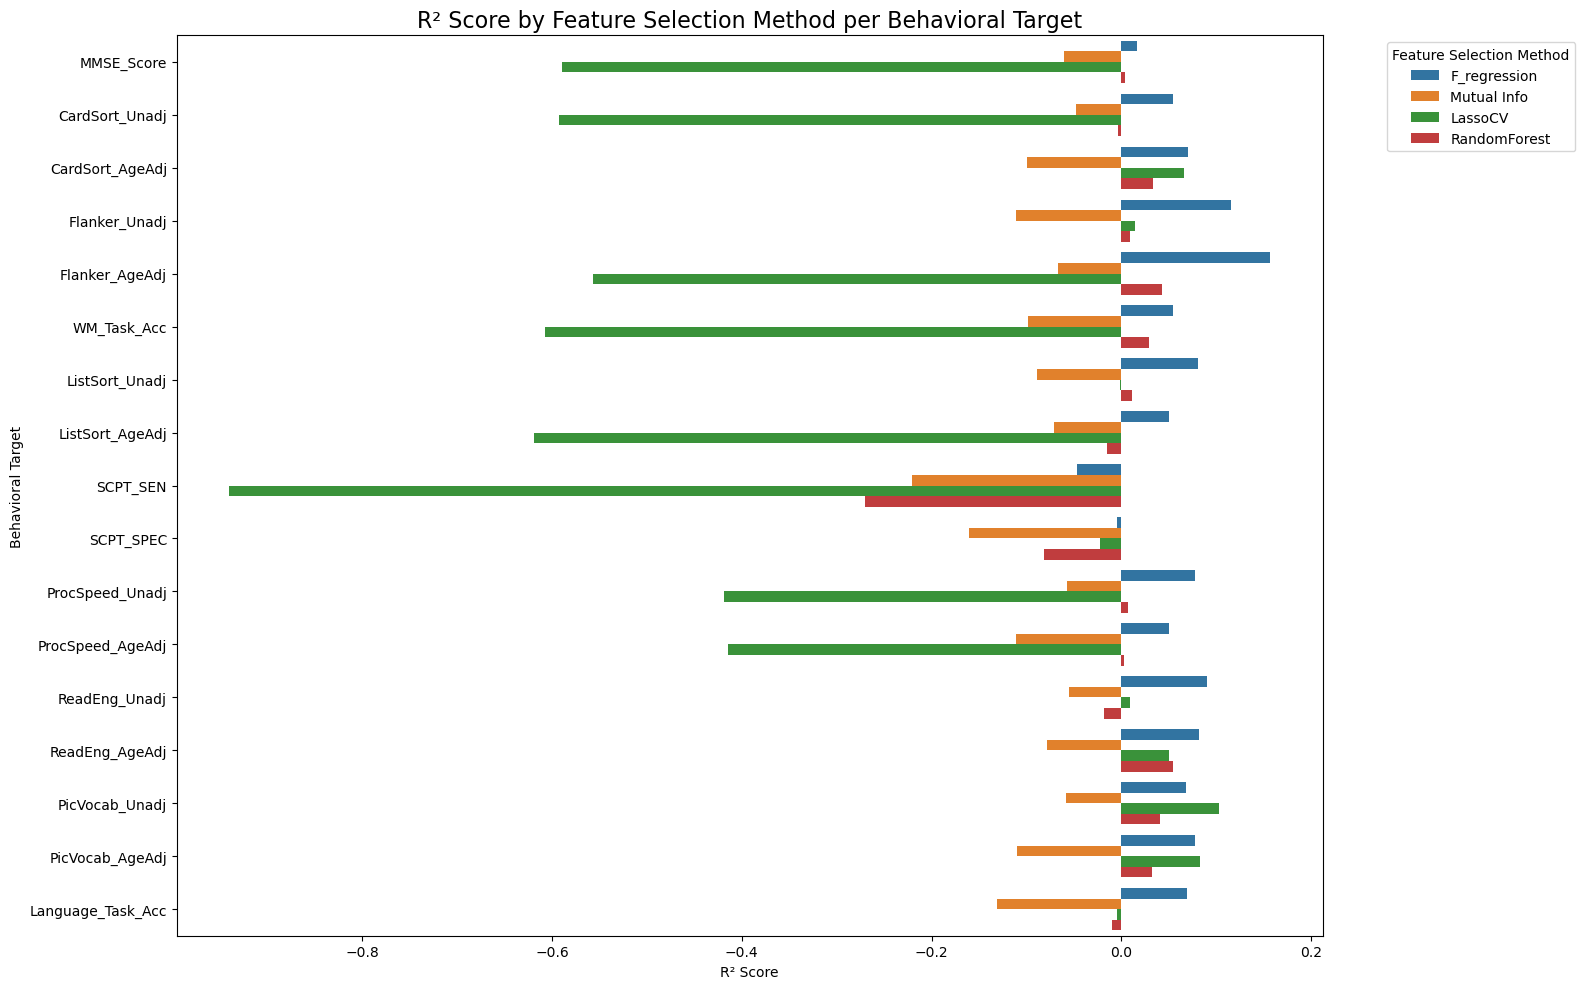

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved feature selection comparison results
fs_results_df = pd.read_csv("features/feature_selection_comparison.csv")

# Melt for visualization
melted_df = fs_results_df.melt(id_vars=["Target", "Best_Method"],
                               value_vars=["F_regression_R2", "MutualInfo_R2", "LassoCV_R2", "RandomForest_R2"],
                               var_name="Method", value_name="R2_Score")

# Clean method names
melted_df["Method"] = melted_df["Method"].str.replace("_R2", "").str.replace("MutualInfo", "Mutual Info")

# Plot R2 scores across methods per target
plt.figure(figsize=(16, 10))
sns.barplot(data=melted_df, x="R2_Score", y="Target", hue="Method")
plt.title("R² Score by Feature Selection Method per Behavioral Target", fontsize=16)
plt.xlabel("R² Score")
plt.ylabel("Behavioral Target")
plt.legend(title="Feature Selection Method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("figures/feature_selection_comparison_r2.png", dpi=300)
plt.show()


In [37]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import pandas as pd

print("\n Extracting best feature set per target using best-performing method...")

# Load input and results
fs_df = pd.read_csv("features/feature_selection_comparison.csv")
X_all = np.load("features/conn_matrix_all.npy")
X_scaled = StandardScaler().fit_transform(X_all)

# Directory to save final selected features
os.makedirs("features/final_selected_features", exist_ok=True)

# Define function to select features using best method
def get_selected_features(X, y, method):
    if method == "F":
        selector = SelectKBest(score_func=f_regression, k=30)
        return selector.fit_transform(X, y)
    elif method == "Mutual Info":
        selector = SelectKBest(score_func=mutual_info_regression, k=30)
        return selector.fit_transform(X, y)
    elif method == "Lasso":
        lasso = LassoCV(cv=3).fit(X, y)
        selector = SelectFromModel(lasso, threshold="mean", prefit=True)
        return selector.transform(X)
    elif method == "RF":
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        top_idx = np.argsort(rf.feature_importances_)[-30:]
        return X[:, top_idx]
    else:
        raise ValueError(f"Unknown method: {method}")

# For each target, extract and save selected features
for _, row in fs_df.iterrows():
    target = row["Target"]
    method = row["Best_Method"]
    print(f" {target} → {method}")

    y = behavior_data[target].values
    mask = ~np.isnan(y)
    X = X_scaled[mask]
    y_clean = y[mask]

    X_selected = get_selected_features(X, y_clean, method)
    np.save(f"features/final_selected_features/{target}_selected.npy", X_selected)
    print(f"    Saved shape: {X_selected.shape}")

print("\n All best-selected features saved per target in features/final_selected_features/")



 Extracting best feature set per target using best-performing method...
 MMSE_Score → F
    Saved shape: (500, 30)
 CardSort_Unadj → F
    Saved shape: (500, 30)
 CardSort_AgeAdj → F
    Saved shape: (500, 30)
 Flanker_Unadj → F
    Saved shape: (500, 30)
 Flanker_AgeAdj → F
    Saved shape: (500, 30)
 WM_Task_Acc → F
    Saved shape: (500, 30)
 ListSort_Unadj → F
    Saved shape: (500, 30)
 ListSort_AgeAdj → F
    Saved shape: (500, 30)
 SCPT_SEN → F
    Saved shape: (500, 30)
 SCPT_SPEC → F
    Saved shape: (500, 30)
 ProcSpeed_Unadj → F
    Saved shape: (500, 30)
 ProcSpeed_AgeAdj → F
    Saved shape: (500, 30)
 ReadEng_Unadj → F
    Saved shape: (500, 30)
 ReadEng_AgeAdj → F
    Saved shape: (500, 30)
 PicVocab_Unadj → Lasso
    Saved shape: (500, 8)
 PicVocab_AgeAdj → Lasso
    Saved shape: (500, 6)
 Language_Task_Acc → F
    Saved shape: (500, 30)

 All best-selected features saved per target in features/final_selected_features/


In [38]:
# Nested CV execution for a single target: "ProcSpeed_Unadj"
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the selected features for the target (best method from previous steps)
target = "ProcSpeed_Unadj"
X = np.load(f"features/final_selected_features/{target}_selected.npy")
y = behavior_data[target].values
mask = ~np.isnan(y)
X = X[mask]
y = y[mask]

# Outer CV for performance evaluation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Inner CV for feature selection and hyperparameter tuning
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Pipeline with PCA option
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduce', 'passthrough'),  # Placeholder for PCA or not
    ('model', Ridge())
])

# Parameter grid to test both PCA and raw features
param_grid = [
    {
        'dim_reduce': [PCA(n_components=0.95)],
        'model__alpha': [0.1, 1.0, 10.0]
    },
    {
        'dim_reduce': ['passthrough'],
        'model__alpha': [0.1, 1.0, 10.0]
    }
]

# Perform nested cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=inner_cv)
nested_scores = cross_val_score(grid, X, y, cv=outer_cv, scoring='r2')

# Fit the full model to analyze best configuration
grid.fit(X, y)
best_dim_reduce = grid.best_estimator_.named_steps['dim_reduce']
best_alpha = grid.best_params_['model__alpha']
best_score = grid.best_score_

{
    "Best R2 (inner CV)": round(best_score, 4),
    "Nested CV R2 Mean": round(nested_scores.mean(), 4),
    "Nested CV R2 Std": round(nested_scores.std(), 4),
    "Best Approach": "PCA" if isinstance(best_dim_reduce, PCA) else "Raw Features",
    "Best Alpha": best_alpha,
    "PCA Variance Explained": round(best_dim_reduce.explained_variance_ratio_.sum(), 4) if isinstance(best_dim_reduce, PCA) else "N/A"
}


{'Best R2 (inner CV)': 0.0889,
 'Nested CV R2 Mean': 0.0848,
 'Nested CV R2 Std': 0.0288,
 'Best Approach': 'PCA',
 'Best Alpha': 10.0,
 'PCA Variance Explained': 0.9594}

In [39]:
# Parallelized nested CV for all behavioral targets
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import NotFittedError
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import os

# CV configs
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Behavioral targets
targets = [
    'MMSE_Score', 'CardSort_Unadj', 'CardSort_AgeAdj',
    'Flanker_Unadj', 'Flanker_AgeAdj', 'WM_Task_Acc',
    'ListSort_Unadj', 'ListSort_AgeAdj', 'SCPT_SEN', 'SCPT_SPEC',
    'ProcSpeed_Unadj', 'ProcSpeed_AgeAdj', 'ReadEng_Unadj', 'ReadEng_AgeAdj',
    'PicVocab_Unadj', 'PicVocab_AgeAdj', 'Language_Task_Acc'
]

# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduce', 'passthrough'),
    ('model', Ridge())
])

param_grid = [
    {'dim_reduce': [PCA(n_components=0.95)], 'model__alpha': [0.1, 1.0, 10.0]},
    {'dim_reduce': ['passthrough'], 'model__alpha': [0.1, 1.0, 10.0]}
]

def run_nested_cv_for_target(target):
    path = f"features/final_selected_features/{target}_selected.npy"
    if not os.path.exists(path):
        return None

    y = behavior_data[target].values
    mask = ~np.isnan(y)
    X = np.load(path)
    X = X[mask]
    y = y[mask]

    if len(y) < 50:
        return None

    try:
        grid = GridSearchCV(pipeline, param_grid, cv=inner_cv)
        nested_scores = cross_val_score(grid, X, y, cv=outer_cv, scoring='r2')
        grid.fit(X, y)

        best_dim_reduce = grid.best_estimator_.named_steps['dim_reduce']
        approach = "PCA" if isinstance(best_dim_reduce, PCA) else "Raw"
        pca_var = round(best_dim_reduce.explained_variance_ratio_.sum(), 4) if approach == "PCA" else "N/A"

        return {
            "Target": target,
            "Best_Approach": approach,
            "Best_Alpha": grid.best_params_['model__alpha'],
            "Best_InnerCV_R2": round(grid.best_score_, 4),
            "NestedCV_R2_Mean": round(nested_scores.mean(), 4),
            "NestedCV_R2_Std": round(nested_scores.std(), 4),
            "PCA_Variance_Explained": pca_var
        }
    except Exception as e:
        return {"Target": target, "Error": str(e)}

# Run in parallel
results_nested = Parallel(n_jobs=20, verbose=10)(
    delayed(run_nested_cv_for_target)(target) for target in targets
)

nested_df = pd.DataFrame([r for r in results_nested if r is not None])
nested_df.to_csv("features/nested_cv_results_all_targets.csv", index=False)
print(" Saved nested CV results to features/nested_cv_results_all_targets.csv")

# Optional: View table in notebook
nested_df


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=20)]: Done   2 out of  17 | elapsed:    5.9s remaining:   44.2s
[Parallel(n_jobs=20)]: Done   4 out of  17 | elapsed:    6.0s remaining:   19.3s
[Parallel(n_jobs=20)]: Done   6 out of  17 | elapsed:    6.0s remaining:   11.0s
[Parallel(n_jobs=20)]: Done   8 out of  17 | elapsed:    6.0s remaining:    6.8s
[Parallel(n_jobs=20)]: Done  10 out of  17 | elapsed:    6.0s remaining:    4.2s
[Parallel(n_jobs=20)]: Done  12 out of  17 | elapsed:    6.1s remaining:    2.5s
[Parallel(n_jobs=20)]: Done  14 out of  17 | elapsed:    6.1s remaining:    1.3s


 Saved nested CV results to features/nested_cv_results_all_targets.csv


[Parallel(n_jobs=20)]: Done  17 out of  17 | elapsed:    6.5s finished


,Target,Best_Approach,Best_Alpha,Best_InnerCV_R2,NestedCV_R2_Mean,NestedCV_R2_Std,PCA_Variance_Explained
0,MMSE_Score,PCA,10.0,0.0482,0.0338,0.0529,0.96
1,CardSort_Unadj,PCA,10.0,0.0860,0.0769,0.0798,0.9573
2,CardSort_AgeAdj,PCA,10.0,0.0881,0.0817,0.0537,0.951
3,Flanker_Unadj,PCA,10.0,0.1519,0.1245,0.0926,0.9629
4,Flanker_AgeAdj,PCA,10.0,0.1719,0.1583,0.0574,0.9554
5,WM_Task_Acc,PCA,10.0,0.0801,0.0737,0.0578,0.9532
6,ListSort_Unadj,PCA,10.0,0.1069,0.0995,0.0722,0.9604
7,ListSort_AgeAdj,PCA,10.0,0.0913,0.0661,0.0489,0.9614
8,SCPT_SEN,PCA,10.0,-0.0108,-0.0279,0.2061,0.9583
9,SCPT_SPEC,PCA,10.0,0.0535,0.0170,0.0637,0.9575


In [41]:
from sklearn.experimental import enable_halving_search_cv  # 👈 Required to enable
from sklearn.model_selection import HalvingGridSearchCV     # 👈 Now import it safely


cuML not available, using CPU models.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.3s
/mmfs1/project/amr239/svs28/anaconda3/envs/hcp_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.897e-01, tolerance: 3.686e-02
  model = cd_fast.enet_coordinate_descent(
/mmfs1/project/amr239/svs28/anaconda3/envs/hcp_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.774e+00, tolerance: 3.686e-02
  model = cd_fast.enet_coordinate_descent(
/mmfs1/project/amr239/svs28/anaconda3/envs/hcp_env/lib/python3.9/site-packages/sklear

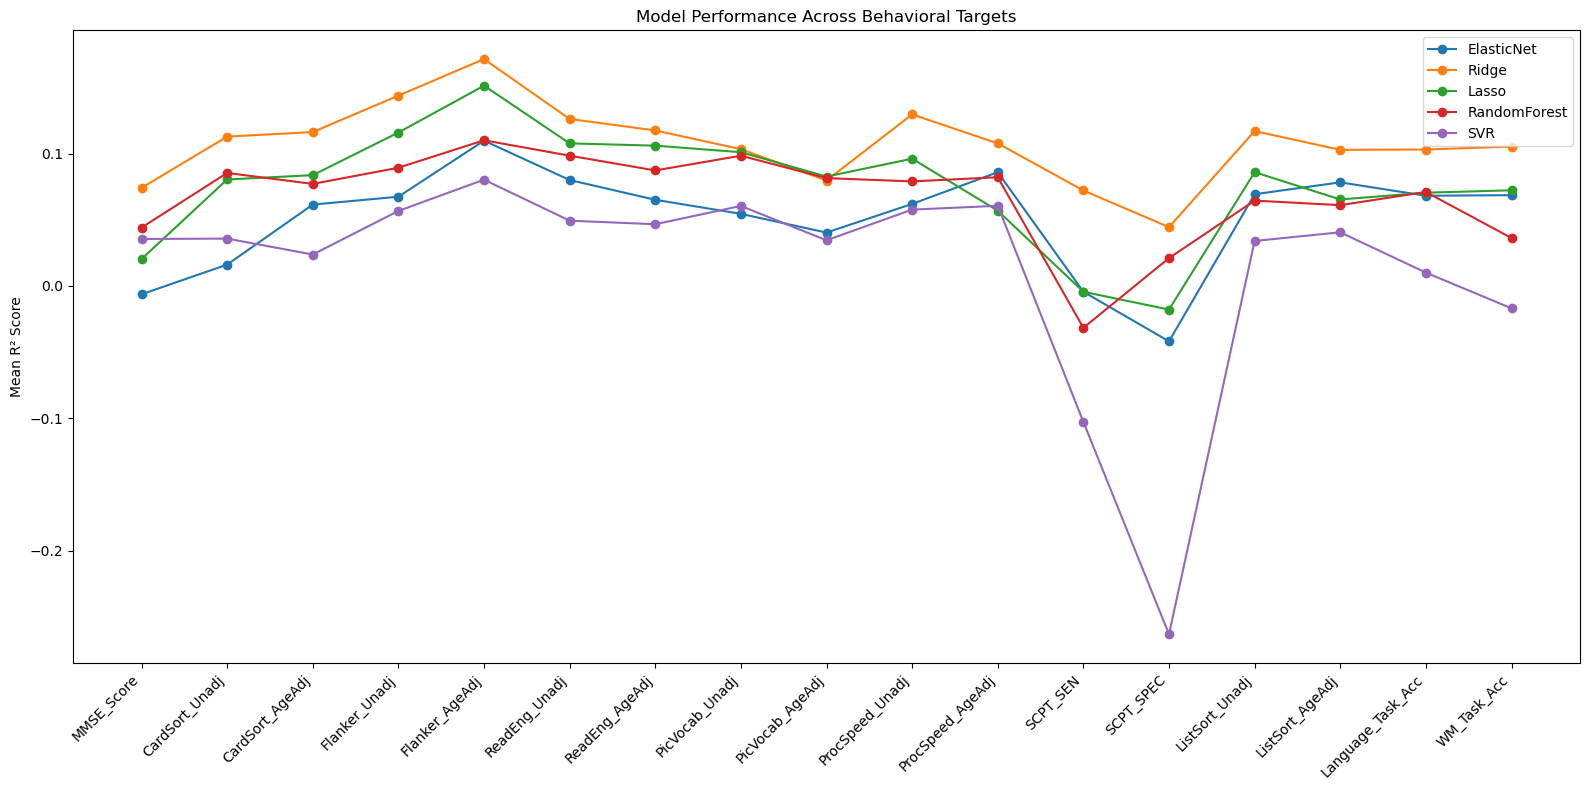


 Best model per target:
               Target  Model   Mean_R2                    Best_Params
11    CardSort_AgeAdj  Ridge  0.116213  {'alpha': 215.44346900318823}
6      CardSort_Unadj  Ridge  0.112756  {'alpha': 215.44346900318823}
21     Flanker_AgeAdj  Ridge  0.171311  {'alpha': 215.44346900318823}
16      Flanker_Unadj  Ridge  0.143728  {'alpha': 215.44346900318823}
76  Language_Task_Acc  Ridge  0.103014  {'alpha': 215.44346900318823}
71    ListSort_AgeAdj  Ridge  0.102785  {'alpha': 215.44346900318823}
66     ListSort_Unadj  Ridge  0.116960  {'alpha': 215.44346900318823}
1          MMSE_Score  Ridge  0.074008              {'alpha': 1000.0}
42    PicVocab_AgeAdj  Lasso  0.082585  {'alpha': 0.2682695795279725}
36     PicVocab_Unadj  Ridge  0.103284   {'alpha': 46.41588833612773}
51   ProcSpeed_AgeAdj  Ridge  0.107672  {'alpha': 215.44346900318823}
46    ProcSpeed_Unadj  Ridge  0.129543  {'alpha': 215.44346900318823}
31     ReadEng_AgeAdj  Ridge  0.117414  {'alpha': 215.44346900318

In [42]:
# Updated full pipeline with improvements, tracking, and parallel support
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold, HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from joblib import Parallel, delayed

# GPU (cuML) imports (if available)
try:
    from cuml.linear_model import Ridge as cuRidge, ElasticNet as cuElasticNet, Lasso as cuLasso
    from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
    from cuml.svm import SVR as cuSVR
    use_gpu = True
    print("cuML (GPU) models available.")
except ImportError:
    use_gpu = False
    print("cuML not available, using CPU models.")

# =========================================
# Model and Parameter Grid Setup
# =========================================
n_cores = 120

if use_gpu:
    models = {
        'ElasticNet': cuElasticNet(max_iter=5000, tol=1e-4),
        'Ridge': cuRidge(solver='eig', fit_intercept=False),
        'Lasso': cuLasso(max_iter=5000, tol=1e-4),
        'RandomForest': cuRandomForestRegressor(
            n_estimators=300, max_features=0.3, max_depth=20, random_state=42
        ),
        'SVR': cuSVR(kernel='rbf', cache_size=8000)
    }
else:
    models = {
        'ElasticNet': ElasticNet(max_iter=10000, random_state=42),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(max_iter=10000, random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42, n_jobs=n_cores),
        'SVR': SVR()
    }

param_grids = {
    'ElasticNet': {
        'alpha': np.logspace(-4, 1, 8),
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    },
    'Ridge': {
        'alpha': np.logspace(-3, 3, 10)
    },
    'Lasso': {
        'alpha': np.logspace(-4, 0, 8)
    },
    'RandomForest': {
        'n_estimators': [200, 300],
        'max_depth': [15, 25, None],
        'min_samples_split': [5, 10],
        'max_features': [0.3, 'sqrt']
    },
    'SVR': {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 0.1],
        'kernel': ['rbf'],
        'epsilon': [0.05, 0.1]
    }
}

# =========================================
# Modeling Function
# =========================================
def model_target(target):
    feature_path = f'features/final_selected_features/{target}_selected.npy'
    if not os.path.exists(feature_path):
        print(f"Skipping {target} — file not found.")
        return []

    y = behavior_data[target].values
    if np.isnan(y).sum() > 50:
        print(f"Skipping {target} — too many missing values.")
        return []

    print(f"\n=== Modeling {target} ===")
    try:
        X = np.load(feature_path)
        mask = ~np.isnan(y)
        y = y[mask]
        X = X[mask]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    except Exception as e:
        print(f" Failed to load/process {target}: {e}")
        return []

    cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)
    target_results = []

    for model_name, model in models.items():
        print(f"  ➤ Starting model: {model_name}")
        param_grid = param_grids[model_name]
        search = HalvingGridSearchCV(
            estimator=model,
            param_grid=param_grid,
            factor=3,
            min_resources='exhaust',
            cv=3,
            scoring='r2',
            n_jobs=n_cores if not use_gpu else 1,
            verbose=0
        )

        outer_scores = []
        fold_num = 0
        for train_idx, test_idx in cv_outer.split(X_scaled, y):
            fold_num += 1
            print(f"    → Fold {fold_num}/5")
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            try:
                search.fit(X_train, y_train)
                best_model = search.best_estimator_
                score = best_model.score(X_test, y_test)
                outer_scores.append(score)
                print(f"      R²: {score:.4f} | Best: {search.best_params_}")
            except Exception as e:
                print(f"       Error in model {model_name}, fold {fold_num}: {e}")
                continue

        if outer_scores:
            target_results.append({
                'Target': target,
                'Model': model_name,
                'Mean_R2': np.mean(outer_scores),
                'Std_R2': np.std(outer_scores),
                'Best_Params': search.best_params_
            })

    return target_results

# =========================================
# Run in Parallel
# =========================================
results = Parallel(n_jobs=10, verbose=10)(
    delayed(model_target)(target) for target in behavior_data.columns
)

# Flatten results
all_results = [res for target_list in results for res in target_list]
results_df = pd.DataFrame(all_results)
results_df.to_csv('model_performance_results.csv', index=False)

# =========================================
# Visualization
# =========================================
plt.figure(figsize=(16, 8))
for model_name in models.keys():
    model_df = results_df[results_df['Model'] == model_name]
    plt.plot(model_df['Target'], model_df['Mean_R2'], marker='o', label=model_name)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean R² Score')
plt.title('Model Performance Across Behavioral Targets')
plt.legend()
plt.tight_layout()
plt.savefig('figures/model_performance_plot.png', dpi=300)
plt.show()

# Best model per target
best_models = results_df.loc[results_df.groupby('Target')['Mean_R2'].idxmax()]
print("\n Best model per target:")
print(best_models[['Target', 'Model', 'Mean_R2', 'Best_Params']])



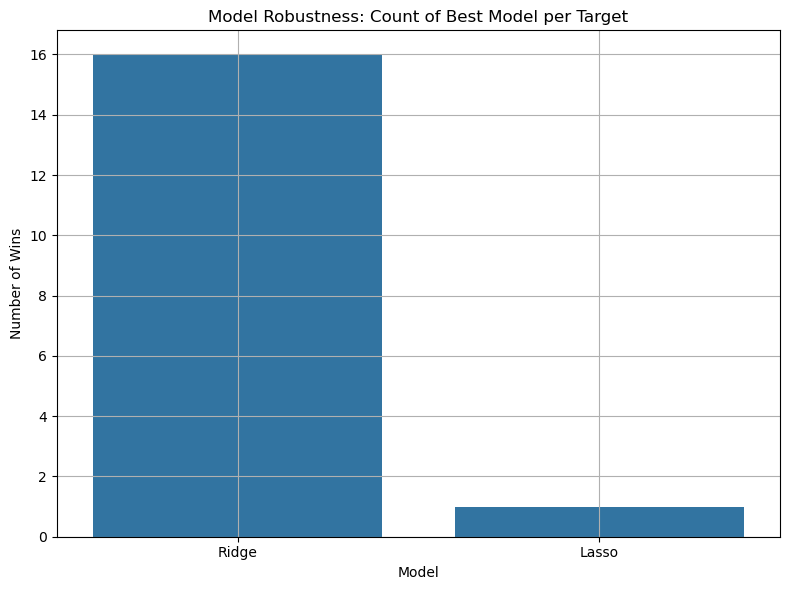

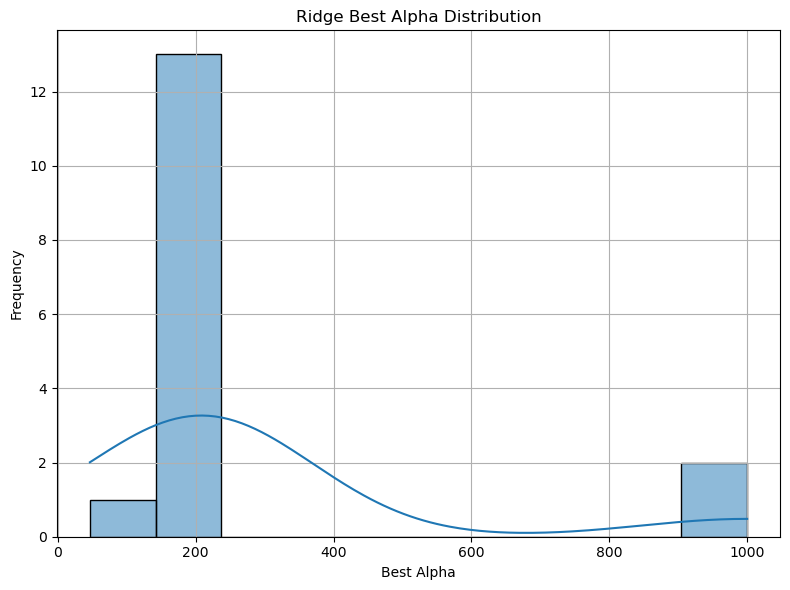

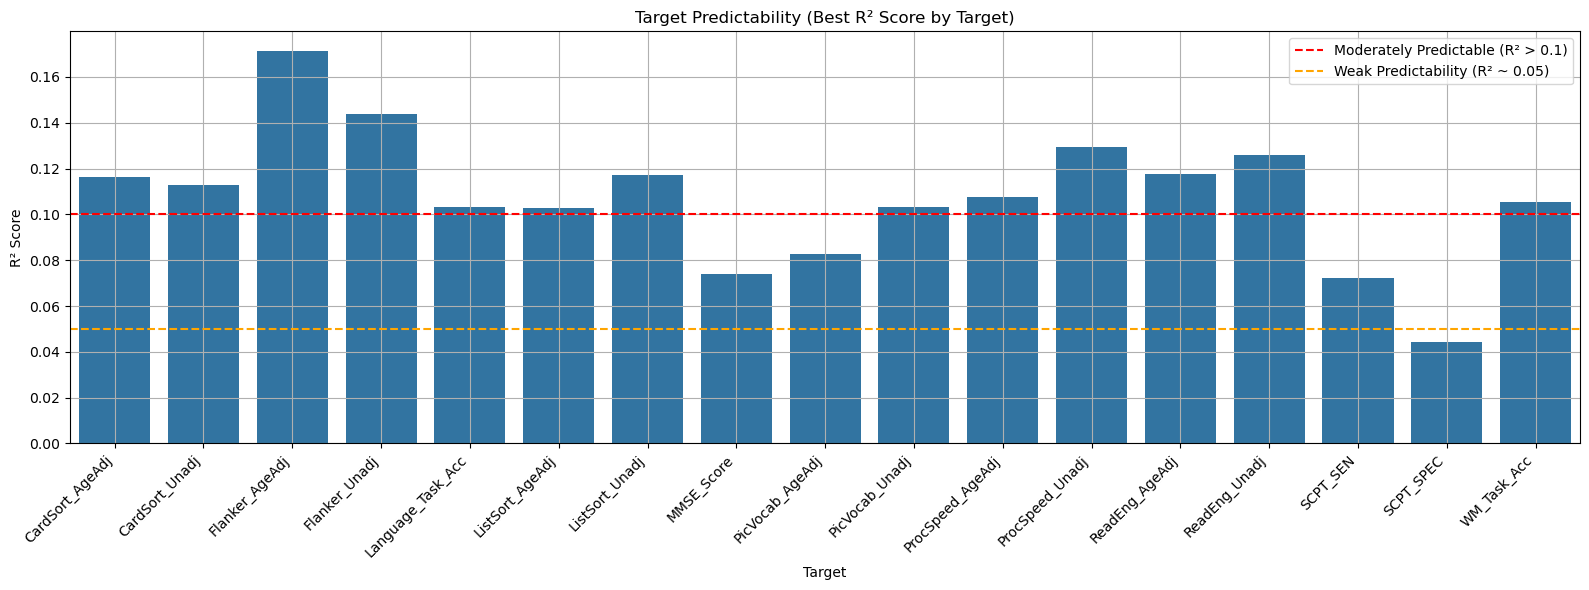

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the results file if not already present
results_df = pd.read_csv("model_performance_results.csv")

# 1. Model Robustness – Count how often each model is best
best_models = results_df.loc[results_df.groupby('Target')['Mean_R2'].idxmax()]
model_counts = best_models['Model'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=model_counts.index, y=model_counts.values)
plt.title("Model Robustness: Count of Best Model per Target")
plt.ylabel("Number of Wins")
plt.xlabel("Model")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/model_robustness_barplot.png", dpi=300)
plt.show()

# 2. Hyperparameter Trends for Ridge
ridge_winners = best_models[best_models['Model'] == 'Ridge']
alphas = [params['alpha'] for params in ridge_winners['Best_Params'].apply(eval)]

plt.figure(figsize=(8, 6))
sns.histplot(alphas, bins=10, kde=True)
plt.title("Ridge Best Alpha Distribution")
plt.xlabel("Best Alpha")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/ridge_alpha_distribution.png", dpi=300)
plt.show()

# 3. Target Difficulty – R² Score per Target
plt.figure(figsize=(16, 6))
sns.barplot(x=best_models['Target'], y=best_models['Mean_R2'])
plt.xticks(rotation=45, ha='right')
plt.axhline(0.1, color='red', linestyle='--', label='Moderately Predictable (R² > 0.1)')
plt.axhline(0.05, color='orange', linestyle='--', label='Weak Predictability (R² ~ 0.05)')
plt.title("Target Predictability (Best R² Score by Target)")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/target_predictability.png", dpi=300)
plt.show()


In [46]:
import os
os.makedirs("summaries", exist_ok=True)

In [47]:
import pandas as pd

# Load final results
results_df = pd.read_csv("model_performance_results.csv")

# Get the best model per target
best_models = results_df.loc[results_df.groupby('Target')['Mean_R2'].idxmax()]

# Clean formatting for readability
summary_table = best_models[['Target', 'Model', 'Mean_R2', 'Std_R2', 'Best_Params']].copy()
summary_table.columns = ['Target', 'Best Model', 'Best R²', 'R² Std Dev', 'Best Parameters']

# Round values for easier interpretation
summary_table['Best R²'] = summary_table['Best R²'].round(4)
summary_table['R² Std Dev'] = summary_table['R² Std Dev'].round(4)

# Sort by best R²
summary_table = summary_table.sort_values(by='Best R²', ascending=False).reset_index(drop=True)

# Save and display
summary_table.to_csv("summaries/best_model_summary.csv", index=False)
summary_table.head(10)  # Show top 10 performing targets


,Target,Best Model,Best R²,R² Std Dev,Best Parameters
0,Flanker_AgeAdj,Ridge,0.1713,0.0379,{'alpha': 215.44346900318823}
1,Flanker_Unadj,Ridge,0.1437,0.0584,{'alpha': 215.44346900318823}
2,ProcSpeed_Unadj,Ridge,0.1295,0.0435,{'alpha': 215.44346900318823}
3,ReadEng_Unadj,Ridge,0.1261,0.0252,{'alpha': 215.44346900318823}
4,ReadEng_AgeAdj,Ridge,0.1174,0.0297,{'alpha': 215.44346900318823}
5,ListSort_Unadj,Ridge,0.1170,0.0565,{'alpha': 215.44346900318823}
6,CardSort_AgeAdj,Ridge,0.1162,0.0320,{'alpha': 215.44346900318823}
7,CardSort_Unadj,Ridge,0.1128,0.0594,{'alpha': 215.44346900318823}
8,ProcSpeed_AgeAdj,Ridge,0.1077,0.0402,{'alpha': 215.44346900318823}
9,WM_Task_Acc,Ridge,0.1052,0.0408,{'alpha': 215.44346900318823}
